# Handwriting character dynamic feature analyze
author: Dmitry Iatsenko 

email:  d.yacenko@gmail.com 

ORCID: 0000-0003-1014-0376 

In [1]:
IMG_FOLDER="chars"
UCI_DATASET="ujipenchars2.txt"
LOCAL_DATASET='dataset'
CURRENT_FOLDER="/home/test/Dissertation/"
CHAR_LIST="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
FOREGROUND="white"
TRAIN_DICT={}
TEST_DICT={}
SCALE_X=4
SMOOTH=True
IMG_W=32 # 60
IMG_H=32 # 60
FEATURES= 'fft_angles' # fft_angles, angles
# # best for me dataset
# TRACK_STEP_LEN=30
# MAX_TRACK_SIZE=10
# BATCH_SIZE=50
# NUM_HIDDEN_NEURON=100
# ITERS=5000
TRACK_STEP_LEN=30 # отступ между оставляемыми точками при прореживании 
MAX_TRACK_SIZE=30 # 40
BATCH_SIZE=50
MODEL='resnet' # resnet, rnn2, rnn, lstm 
NUM_HIDDEN_NEURON=100
EPOCHS=100
BATCHNORM=True # не работает train/eval по неизвестной причине
DROPOUT=True
DATASET='uji'# russian,uji
IMG_DIVIDER= 100 if DATASET=="uji" else 1.1
ACTIVATION='lrelu' # rrelu,relu, tanh , lrelu, hardswish

In [2]:
from __future__ import print_function, division

import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from IPython.display import clear_output
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import scipy
import math
import scipy.interpolate as si
from scipy import interpolate
import pickle
import os.path
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# plt.style.use('dark_background')
#%matplotlib inline

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

# Presentation classes.
Define classes for represent bases objects - point, polyline, char

In [20]:
class Point:
  def __init__(self,x,y):
    self.x=x
    self.y=y
  def __str__(self):
    return "("+str(self.x)+","+str(self.y)+")"
  __repr__ = __str__


class Poly:
  def __init__(self):
    self.points=[]
    self.angles=[]
    self.lens=[]
    self.times=[]
    self.speeds=[]
    self.fft_angles=[]
    self.fft_speeds=[]
    self.image=[]
  def add(self,point,time=None):
    self.points.append(point)
    if not time is None:
      self.times.append(time)
  def calculate_angles(self):
    if len(self.points)==0:
      return
    if len(self.points)==1:
      self.angles.append(0)
      self.lens.append(0)
      return
    for i in range(0,len(self.points)-1):
      angle=math.atan2(self.points[i+1].y-self.points[i].y,self.points[i+1].x-self.points[i].x)
      if angle<0: angle=2*math.pi+angle
      self.angles.append(angle)
      self.lens.append(math.sqrt((self.points[i+1].y-self.points[i].y)**2+(self.points[i+1].x-self.points[i].x)**2))
  def calculate_image(self):
    if len(self.points)==0:
      return 
    self.image = [ [0] * IMG_W for _ in range(IMG_H)] 
    for p in self.points:
      H=int(p.y/IMG_DIVIDER)
      W=int(p.x/IMG_DIVIDER)
      if W>=IMG_W or  H>=IMG_H: continue
      self.image[H][W]=255
      pass
  def calc_angle(self,point,other):
    angle=0
    for p in other:
      a=math.atan2(p.y-point.y,p.x-point.x)
      if a<0: a+=2*math.pi
      angle+=a
    return angle/len(other)  
  def calc_dist(self,point1,point2):
    return math.sqrt((point2.x-point1.x)**2+(point2.y-point1.y)**2)
  def calc_fft(self,sequence):
    DURATION=1
    SAMPLE_RATE=len(sequence)
    N = SAMPLE_RATE * DURATION
    yf = rfft(sequence)
    xf = rfftfreq(N, 1 / SAMPLE_RATE)
    return xf, np.abs(yf)

  def calc_vo_smothie(self):
    self.drop_dup() 
    if len(self.points)==1:
      return
    for i in range(0,len(self.points)-1):
      dx=self.points[i+1].x-self.points[i].x
      dy=self.points[i+1].y-self.points[i].y
      self.lens.append(math.sqrt(dx**2+dy**2))
      angle=self.calc_angle(point=self.points[i],other=[self.points[i+1]])
      self.angles.append(angle)
      if len(self.times)>0:self.speeds.append(self.lens[-1]/self.times[i])
    _,self.fft_angles=self.calc_fft(self.angles) 
    _,self.fft_speeds=self.calc_fft(self.speeds)

  def calc_vs_smothie(self):
    self.drop_dup() 
    if len(self.points)==1:
      return
    f=[]
    for i in range(0,len(self.points)):
      if i!=0:
        f_=[(self.points[i].x-self.points[i-1].x),(self.points[i].y-self.points[i-1].y)]
        f.append(f_)
    v=np.array([0,0])
    m=1000
    nu=40
    x1=[]
    y1=[]
    x1.append(self.points[0].x)
    y1.append(self.points[0].y)
    #строим новую сглаженную траекторию
    for i in range(0,len(f)):
      for j in range(0,40):
        x1_=x1[-1]+v[0]  
        y1_=y1[-1]+v[1]
        f_=np.array(f[i])
        v=v+f_/m-nu*v/m
        x1.append(x1_)
        y1.append(y1_)    
    #прореживаем и считаем углы и длинны    
    self.lens=[]
    self.angles=[]
    self.points=[]
    self.points.append(Point(x1[0],y1[0]))
    angle=self.calc_angle(point=self.points[0], other=[Point(x1[1],y1[1]),Point(x1[2],y1[2]),Point(x1[3],y1[3])])
    self.angles.append(angle)
    step=0.
    for i in range(1,len(x1)-3):
      step+=self.calc_dist(self.points[-1],Point(x1[i],y1[i]))
      if step>TRACK_STEP_LEN:
        self.points.append(Point(x1[i],y1[i]))
        angle=self.calc_angle(self.points[-1],[Point(x1[i+1],y1[i+1]),Point(x1[i+2],y1[i+2]),Point(x1[i+3],y1[i+3])]) 
        self.angles.append(angle)
        self.lens.append(step)
        step=0.
    _,self.fft_angles=self.calc_fft(self.angles) 

  def drop_dup(self):
    nodup_points=[]
    nodup_times=[]
    for i in range(0,len(self.points)-1):
      if self.points[i].x!=self.points[i+1].x or self.points[i].y!=self.points[i+1].y:
        nodup_points.append(self.points[i])
        if len(self.times)>0:nodup_times.append(self.times[i])
    if len(nodup_points)==0:
      nodup_points.append(self.points[0])    
      if len(self.times)>0: nodup_times.append(self.times[0])    
    self.points=nodup_points
    if len(self.times)>0: self.times=nodup_times
  def move(self,dx,dy):
    for p in self.points:
      p.x+=dx
      p.y+=dy

  def get_min(self):
    min_x = self.points[0].x
    min_y = self.points[0].y
    for p in self.points:
      if min_x>p.x: min_x=p.x
      if min_y>p.y: min_y=p.y
    return min_x,min_y  

  def __len__(self):
    return len(self.points)-1


class Char:
  def __init__(self,name):
    self.name=name
    self.polys=[]
  def singlePolys(self):
      single=Poly()
      for poly in self.polys:
        if len(poly.points)>1:
          single.points.extend(poly.points)
          single.angles.extend(poly.angles)
          single.lens.extend(poly.lens)
          single.times.extend(poly.times)
          single.speeds.extend(poly.speeds)
          single.fft_angles.extend(poly.fft_angles)
          single.fft_speeds.extend(poly.fft_speeds)
      return single
  def singleImage(self):
    if len(self.polys) ==1: 
      return self.polys[0].image
    self.image = [ [0] * IMG_W for _ in range(IMG_H)] 
    for poly in  self.polys:
      for j in range(IMG_H):
        for i in range(IMG_W):
          # print("{},{}".format(j,i))
          if poly.image[j][i] +  self.image[j][i] == 0:
            continue
          else:
            self.image[j][i] =255   
    return self.image

  def appendPoly(self):
    self.polys.append(Poly());
  def appendPoint(self,point,time=None):
    self.polys[-1].add(point,time)
  def flip_vert(self):
    for poly in self.polys:
      for point in poly.points:
        point.y=5000-point.y
  def flip_hor(self):
    for poly in self.polys:
      for point in poly.points:
        point.x=10040-point.x
  def calculate_angles(self):
    for poly in self.polys:
      poly.calculate_angles()
  def calculate_images(self):
    for poly in self.polys:
      poly.calculate_image()    
  def drop_dup(self):
    for poly in self.polys:
      poly.drop_dup()
  def calc_vs_smothie(self):
    for poly in self.polys:
      poly.calc_vs_smothie() 
    self.calculate_images()     
  def calc_vo_smothie(self):
    for poly in self.polys:
      poly.calc_vo_smothie()    
    self.calculate_images()  
  def get_min(self):
    min_x,min_y=self.polys[0].get_min()
    for i in range(1,len(self.polys)):
      min_x_,min_y_=self.polys[i].get_min()
      if min_x>min_x_: min_x=min_x_
      if min_y>min_y_: min_y=min_y_
    return min_x,min_y 
  def move (self):
    min_x,min_y=self.get_min()
    for p in self.polys:
      p.move(-min_x,-min_y)

  def __len__(self):
    len_=0
    for poly in self.polys: 
      len_+=len(poly)
    return len_
  def __str__(self):
    s=""
    for _ in self.polys:
      s+="_"+str(len(_.points))
    return self.name + s
  __repr__ = __str__

def addTrainChar(name,char):
  if TRAIN_DICT.get(name) == None:
    TRAIN_DICT[name]=[]
  TRAIN_DICT[name].append(char)


def addTestChar(name,char):
  if TEST_DICT.get(name) == None:
    TEST_DICT[name]=[]
  TEST_DICT[name].append(char)

def plot_curve1(plt,ax,char):
 if ax is None:
        fig, ax = plt.subplots()
 for poly in char.polys:
    x_=[]
    y_=[]  
    for i in range(0,len(poly.points)):
      x_.append(poly.points[i].x)
      y_.append(poly.points[i].y)
    ax.plot( x_ ,y_,'r.')

def plot_curve2(plt,ax,char):
    if ax is None:
        fig, ax = plt.subplots()
    for poly in char.polys:
      for i in range(0,len(poly.points)):
        if i==len(poly.points)-1:
          break
        x_=[]
        y_=[]  
        x_.append(poly.points[i].x)
        x_.append(poly.points[i+1].x)
        y_.append(poly.points[i].y)
        y_.append(poly.points[i+1].y)
        len_=math.sqrt((x_[1]-x_[0])**2+(y_[1]-y_[0])**2)
        ax.plot( x_ ,y_,linewidth=5,color=str(3*len_/255.))

def plot_curve3(plt,ax,char):
    if ax is None:
        fig, ax = plt.subplots()
    len_=0
    for poly in char.polys:
      for i in range(0,len(poly.lens)-1):
        x_=[]
        y_=[]
        x_.append(len_)
        len_+=poly.lens[i]
        x_.append(len_)
        y_.append(poly.angles[i])
        y_.append(poly.angles[i+1])
        ax.set_xlabel("Point, N")
        ax.set_ylabel("Angle, rad")
        ax.plot( x_ ,y_,linewidth=2,color='b')

def plot_curve4(plt,ax,char):
    if ax is None:
        fig, ax = plt.subplots()
    x_=[]
    y_=[]  
    len_=0
    for poly in char.polys:
      for i in range(0,len(poly.speeds)):
        len_+=poly.lens[i]
        x_.append(len_)
        y_.append(poly.speeds[i])
    ax.plot( x_ ,y_,linewidth=2,color='g')

def plot_curve5(plt,ax,char):
    if ax is None:
        fig, ax = plt.subplots()
    img=char.singleImage()
    img=np.array(img)
    ax.imshow(img, origin='lower')



# Load raw local dataset  

In [5]:
def build_local_datatset():
  fn=os.path.join(CURRENT_FOLDER, LOCAL_DATASET)
  dirs=os.listdir(fn)
  for dir in dirs:
    for fi in os.listdir(os.path.join(fn,dir)):
      if len(fi)==1:
        with open(os.path.join(fn,dir,fi), encoding="utf-8") as f,open(os.path.join(fn,dir,fi+"_times"), encoding="utf-8") as ft:
          try:
            data = eval(f.readline())
            times=eval(ft.readline())
          except:
            data=[]
            times=[]  
          print("{}/{}/{}  ({}:{})".format(fn,dir,fi,len(data),len(times)))
          class_name=fi
          char_=Char(fi)
          char_.appendPoly()
          j=0
          for i in range(len(data)//2):
            x=int(data[j])
            y=int(data[j+1])
            t=int(times[i])
            j+=2
            char_.appendPoint(Point(x,y),t)
          char_.move()  
          if len(data) > 0: 
            if SMOOTH:
              char_.calc_vs_smothie()  
            else:
              char_.calc_vo_smothie()    
            if random.random()<0.8: 
              addTrainChar(class_name,char_)
            else: 
              addTestChar(class_name,char_)

      

#Load UCI dataset

In [6]:
def build_uci_datatset():
  fn=os.path.join(CURRENT_FOLDER, UCI_DATASET)
  i=0
  with open(fn, encoding="utf-8") as file:
    i+=1
    file_contents = file.read()
  step_0 = file_contents.split('//')
  del(step_0[0]); del(step_0[0]); del(step_0[0]); del(step_0[0])
  for block in step_0:
    try:
      class_name=block.split()[2]
    except Exception:
      i+=1
      continue
    # отбрасываем лишние    
    if CHAR_LIST.find(class_name) == -1: 
      i+=1
      continue 
    words=block.split('WORD')
    del(words[0])
    wordnum=0
    for word in words:
      if len(class_name)>1:
        continue
      char_=Char(class_name)
      print(class_name, end='')
      # sys.stdout.write(f"\r{class_name}") 
      # analize character
      # count graphical elements in character
      num_word_elements=int(word.split('NUMSTROKES')[1].split()[0])
      for j in range(num_word_elements):
        # get graphical elements in character
        word_elements=word.split('POINTS')
        ##print(word_elements[0]) # Здесь "b trn_UJI_W01-02"
        #scale=1
        #if word_elements[0].find("UPV")!=-1: scale=1/1.52
        #sample_type="trn"
        #if word_elements[0].find("tst_")!=-1: sample_type="tst"
        del(word_elements[0])
        char_.appendPoly()
        points=word_elements[j].split()
        del(points[0])
        del(points[0])
        for x,y in zip(points[0::2], points[1::2]):
          #char_.appendPoint(Point(int(scale*int(x)),int(scale*int(y))))
          char_.appendPoint(Point(int(x)*SCALE_X,int(y)*SCALE_X))
      wordnum+=1
      char_.flip_vert()
      # char_.flip_hor()
      char_.move()
      if SMOOTH:
        char_.calc_vs_smothie()  
      else:
        char_.calc_vo_smothie()   
      char_.calc_vs_smothie()
      # if sample_type=="trn":
      #   addTrainChar(class_name,char_)
      # else:
      #   addTestChar(class_name,char_)  
      if  random.random()<0.8:
        addTrainChar(class_name,char_)
      else:
        addTestChar(class_name,char_)  
    i+=1

# Prepare dataset. 
Load from source, transform to internal form. Save and load to intermediate storage datasert file.

In [7]:
# #remove dataset files for rebuild
# !rm test_dict.p
# !rm train_dict.p

In [8]:


class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
       if name == 'Char' and __name__ != "__main__":
            from Prepare_Dataset import Char
            return Char
       if name == 'Poly' and __name__ != "__main__":
            from Prepare_Dataset import Poly
            return Poly
       if name == 'Point' and __name__ != "__main__":
            from Prepare_Dataset import Point
            return Point
       return super().find_class(module, name)

class CustomPickler(pickle.Pickler):
    def find_class(self, module, name):
       if name == 'Char' and __name__ != "__main__":
            from Prepare_Dataset import Char
            return Char
       if name == 'Poly' and __name__ != "__main__":
            from Prepare_Dataset import Poly
            return Poly
       if name == 'Point' and __name__ != "__main__":
            from Prepare_Dataset import Point
            return Point
       return super().find_class(module, name)


def run_():
  global TRAIN_DICT
  global TEST_DICT
  if os.path.exists(os.path.join(CURRENT_FOLDER,'train_dict.p')):
    f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict.p'), 'rb')
    f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict.p'), 'rb')
    TRAIN_DICT = CustomUnpickler(f_train_dict).load()
    TEST_DICT = CustomUnpickler(f_test_dict).load()
    f_train_dict.close()
    f_test_dict.close()
  else:
    if DATASET == 'russian':
      build_local_datatset()
    else:
      build_uci_datatset()
    f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict.p'), 'wb')
    f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict.p'), 'wb')
    CustomPickler(f_train_dict).dump(TRAIN_DICT)
    CustomPickler(f_test_dict).dump(TEST_DICT)
    f_train_dict.close()
    f_test_dict.close()



In [9]:
if __name__ == "__main__":
    run_()

## Visualize dataset

30


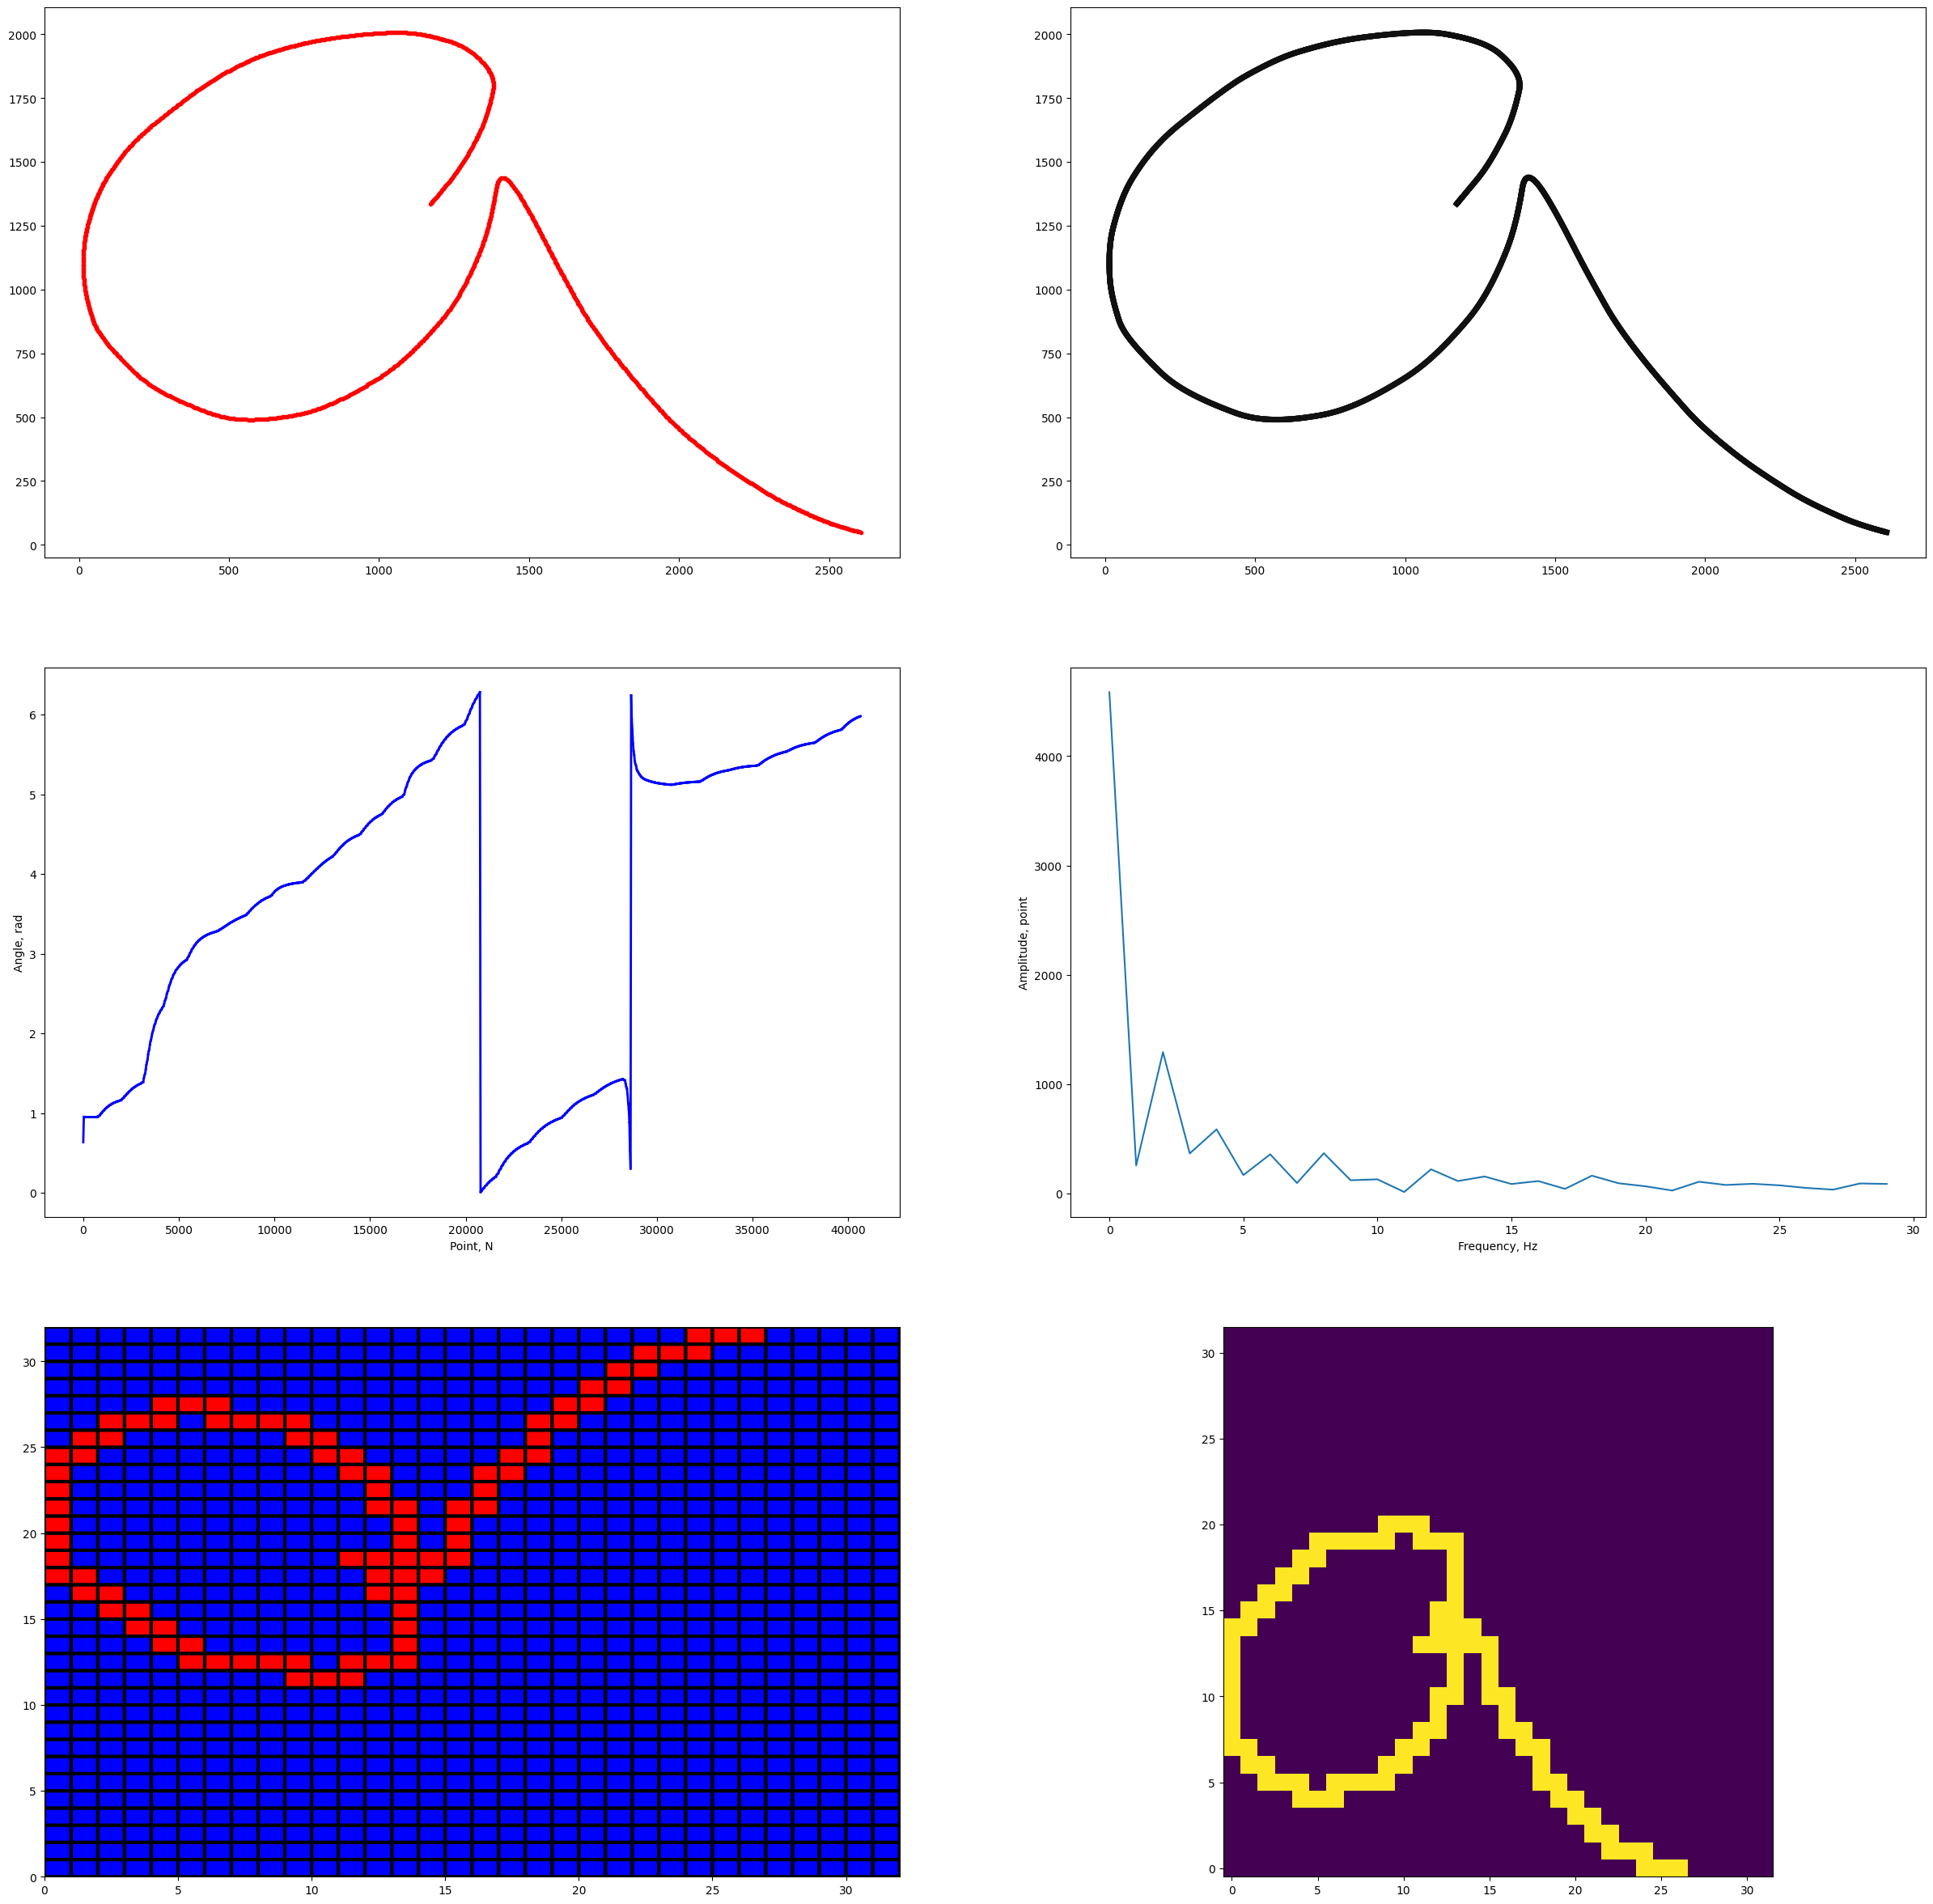

In [24]:
####################################
# #for spanish# build_uci_datatset()
####################################
CHAR='a'
CNUM = 1
# print(TRAIN_DICT[CHAR][CNUM].polys[0].points)
# TRAIN_DICT[CHAR][CNUM]
fig = plt.figure(figsize = (30,30))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)
ax6 = fig.add_subplot(3,2,6)
plot_curve1(plt,ax1,TRAIN_DICT[CHAR][CNUM])
plot_curve2(plt,ax2,TRAIN_DICT[CHAR][CNUM])
plot_curve3(plt,ax3,TRAIN_DICT[CHAR][CNUM])
plot_curve4(plt,ax5,TRAIN_DICT[CHAR][CNUM])
plot_curve5(plt,ax6,TRAIN_DICT[CHAR][CNUM])
xf=np.arange(0, MAX_TRACK_SIZE, 1, dtype=float)
print(len(xf))
extent = ax3.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('fig_angles_'+CHAR+str(CNUM)+'.png', bbox_inches=extent.expanded(1.1, 1.2))
ax4.plot(xf, TRAIN_DICT[CHAR][CNUM].polys[0].fft_angles[:MAX_TRACK_SIZE])
ax4.set_xlabel("Frequency, Hz")
ax4.set_ylabel("Amplitude, point")
extent = ax4.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('fig_fft_'+CHAR+str(CNUM)+'.png', bbox_inches=extent.expanded(1.2, 1.2))

# # ax6.plot(xf, TRAIN_DICT[CHAR][CNUM].polys[0].fft_speeds)
from matplotlib import colors
cmap = colors.ListedColormap(['Blue','red'])
ax5.pcolor(TRAIN_DICT[CHAR][CNUM].singleImage()[::-1],cmap=cmap,edgecolors='k', linewidths=3)
# # print(TRAIN_DICT[CHAR][CNUM].polys[0].image)

extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('fig_char_'+CHAR+str(CNUM)+'.png', bbox_inches=extent.expanded(1.1, 1.2))

extent = ax6.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('fig_pix_char_'+CHAR+str(CNUM)+'.png', bbox_inches=extent.expanded(1.1, 1.2))

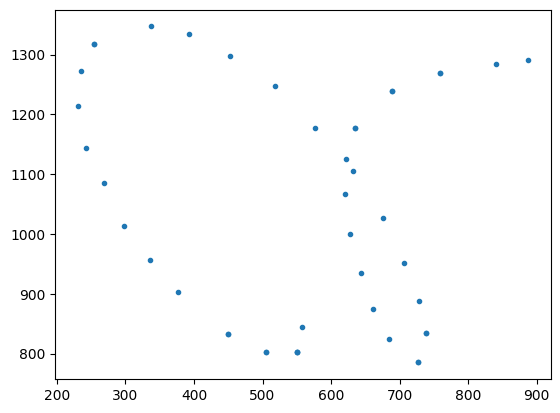

In [11]:
a_1=[557,844,550,803,550,803,550,803,505,803,505,803,450,833,450,833,377,903,336,957,298,1014,268,1086,242,1144,230,1214,235,1272,254,1317,254,1317,337,1347,392,1334,452,1298,518,1247,577,1178,632,1105,676,1026,707,951,728,888,739,835,739,835,727,785,727,785,684,824,661,875,643,935,628,1000,621,1066,622,1126,635,1177,635,1177,689,1239,689,1239,759,1269,759,1269,841,1285,888,1291]
X=np.array([])
Y=np.array([])
for i in range(0,len(a_1),2):
    X=np.append(X,a_1[i])
    Y=np.append(Y,a_1[i+1])
plt.scatter(X,Y,marker='.')
plt.savefig('fig_vec_orig_char_'+CHAR+str(CNUM)+'.png')

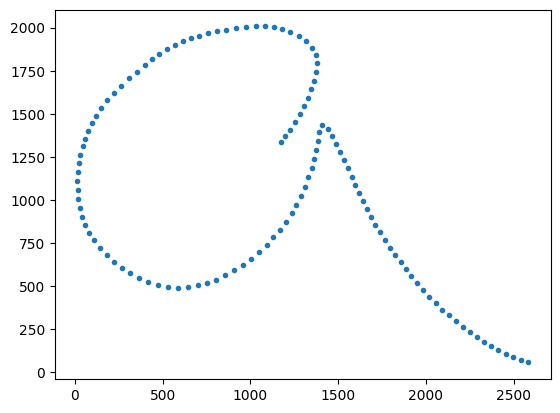

In [12]:
X=np.array([])
Y=np.array([])
for pair in TRAIN_DICT[CHAR][CNUM].polys[0].points:
    X=np.append(X,pair.x)
    Y=np.append(Y,pair.y)
plt.scatter(X[::10],Y[::10],marker='.')
plt.savefig('fig_vec_norm_char_'+CHAR+str(CNUM)+'.png')

In [13]:
# poly=TRAIN_DICT[CHAR][CNUM].polys[0]
# image = [ [0] * IMG_W for _ in range(IMG_H)] 
# # print(image)
# for p in poly.points:
#     y=int(p.y/IMG_DIVIDER)
#     x=int(p.x/IMG_DIVIDER)
#     print("{},{}".format(y,x))
#     image[y][x]=255
# print("---")
# # print(image)
# plt.pcolor( image)
# plt.show()
# # print(image)

In [14]:
######################################
# #for russian# build_local_datatset()
######################################
# CHAR='А'
# CNUM =1
# print(TRAIN_DICT[CHAR])
# TRAIN_DICT[CHAR][CNUM]
# fig = plt.figure(figsize = (12,12))
# ax1 = fig.add_subplot(3,3,1)
# ax2 = fig.add_subplot(3,3,2)
# ax3 = fig.add_subplot(3,3,3)
# ax4 = fig.add_subplot(3,3,4)
# ax5 = fig.add_subplot(3,3,5)
# ax6 = fig.add_subplot(3,3,6)
# plot_curve1(plt,ax1,TRAIN_DICT[CHAR][CNUM])
# plot_curve2(plt,ax2,TRAIN_DICT[CHAR][CNUM])
# plot_curve3(plt,ax3,TRAIN_DICT[CHAR][CNUM])
# plot_curve4(plt,ax5,TRAIN_DICT[CHAR][CNUM])

# xf=np.arange(0, len(TRAIN_DICT[CHAR][CNUM].polys[0].fft_angles), 1, dtype=float)
# print(len(xf))
# ax4.plot(xf, TRAIN_DICT[CHAR][CNUM].polys[0].fft_angles)
# # ax6.plot(xf, TRAIN_DICT[CHAR][CNUM].polys[0].fft_speeds)


In [15]:
# print(TRAIN_DICT)
# print(TEST_DICT)
CHAR_LIST=list(TRAIN_DICT.keys())
CHAR_LIST.sort()
print(len(list(TRAIN_DICT.keys())))
print(list(TRAIN_DICT.keys()).sort())
print(len(list(TEST_DICT.keys())))
print(list(TEST_DICT.keys()).sort())
all_size=0
for key in TRAIN_DICT.keys():
  all_size+=len(TRAIN_DICT[key])

#=====================
# Count iterates from epochs and dataset size
ITERS=all_size//BATCH_SIZE*EPOCHS
print(ITERS)

62
None
62
None
11800


### Support tools

In [27]:
def string_vectorizer(strng, alphabet=CHAR_LIST):
    vector = [[0 if char != letter else 1 for char in alphabet] 
                  for letter in strng]
    return vector

In [28]:
def get_batch(dict,size=BATCH_SIZE):
  chars=random.sample(dict.keys(),size)
  rez=[]
  for c in chars:
    rez.extend(random.sample(dict[c],1))
  return rez  

def get_batch_img(dict,size=BATCH_SIZE):
  chars=random.sample(dict.keys(),size)
  rez1=[]
  rez2=[]  
  names=[]  
  for c in chars:
    char=random.sample(dict[c],1)
    for c_n in char:
        names.append(c_n.name)
        rez1.append(np.array(c_n.singleImage())[None,...])
        rez2.append(c_n)
  return rez1,names,rez2  


# print(get_batch(TRAIN_DICT,10))

In [29]:
def to_matrix(data, max_len=MAX_TRACK_SIZE, dtype='int32'):
  """Casts a list of tracks into rnn-digestable matrix"""
  # data_ix = np.zeros([len(data)*2, max_len], dtype) 
  data_ix = np.zeros([len(data), max_len], dtype) 
  j=0
  for i in range(len(data)):
    if FEATURES=='fft_angles': 
      line_ix = data[i].singlePolys().fft_angles
    else:
      line_ix = data[i].singlePolys().angles  
    # line_ix1 = data[i].singlePolys().fft_speeds 
    data_ix[j, :len(line_ix)] = line_ix[:max_len]
    j+=1
    # data_ix[j, :len(line_ix1)] = line_ix1[:max_len] 
    # j+=1
  return data_ix 
# print(to_matrix(get_batch(TRAIN_DICT,5)))

In [30]:
def to_imagebatch(data):
  data_ix = []
  j=0
  for i in range(len(data)):
    data_ix.append(data[i].singleImage())
  return data_ix 
# print(to_imagebatch(get_batch(TRAIN_DICT,5)))

In [31]:
def getActivateFunction():
  if ACTIVATION == 'rrelu':
    return torch.nn.RReLU()
  elif ACTIVATION == 'relu':
    return torch.nn.ReLU()
  elif ACTIVATION == 'lrelu':
    return torch.nn.LeakyReLU()
  elif ACTIVATION == 'hardswish':
    return torch.nn.Hardswish()
  else:
    return torch.nn.Tanh()

### Define CNN model

In [32]:


class CNNCell(torch.nn.Module):
    def __init__(self,channel=1,num_out=len(CHAR_LIST)):
        super(CNNCell, self).__init__()
        self.SHOW=0
        self.layers=torch.nn.ModuleList()  

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(1, 20, 3))
        l.append(getActivateFunction())
        l.append(torch.nn.MaxPool1d(2))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=20))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(20, 30, 3))
        l.append(getActivateFunction())
        l.append(torch.nn.MaxPool1d(2))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=30))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(30, 10, 3))
        l.append(getActivateFunction())
        l.append(torch.nn.MaxPool1d(2))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=10))

        self.ga = torch.nn.AdaptiveMaxPool1d(2)
        self.flat = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(2*10,num_out)
        # self.cactiv4 = torch.nn.Sigmoid()
        # self.fc2 = torch.nn.Linear(1024,num_out)
        #self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self._forward(x)      
        x = self.fc1(x)
        # x = self.cactiv4(x)
        # x = self.fc2(x)
        return x

    def _forward(self, x):
        n=1 
        x =  x[:,None,:]

        for layer in self.layers:
          for elem in layer:
            x=elem(x)
            if self.SHOW==0: print("--->   {}".format(x.shape))   
          n+=1 
          if self.SHOW==0: print("====")  
        self.SHOW+=1
        x = self.ga(x)

        x = self.flat(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        #x = self.sm(x)
        return x
    
    def _inference(self, x):
        x = self._forward(x)
        #x = self.sm(x)
        return x

# RNN model

*Define model RNN*

In [33]:
class RNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_inputs, num_classes, rnn_num_units=NUM_HIDDEN_NEURON):    
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units        

        self.rnn_update = nn.Linear(num_inputs + rnn_num_units, rnn_num_units)
        self.activate = getActivateFunction() 
        self.batchnorm = nn.BatchNorm1d(num_features=self.num_units)
        self.dropout = torch.nn.Dropout(0.05)
      
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_classes)
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # x=torch.tensor(x, dtype=torch.int64)
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h) 
        h_next=self.activate.forward(h_next)
    
        if BATCHNORM: h_next = self.batchnorm(h_next)
        if DROPOUT: h_next = self.dropout(h_next)
     
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        # return h_next, F.log_softmax(logits, -1)
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units,dtype=torch.float32))

*Define model RNN2*

In [34]:
class RNN2Cell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_inputs, num_classes, rnn_num_units=NUM_HIDDEN_NEURON):    
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units        

        self.rnn_update = nn.Linear(num_inputs + rnn_num_units, rnn_num_units)
        self.activate = getActivateFunction() 
        self.batchnorm = nn.BatchNorm1d(num_features=self.num_units)
        self.dropout = torch.nn.Dropout(0.05)
        self.rnn_update1 = nn.Linear(num_inputs + rnn_num_units, rnn_num_units)
        self.activate1 = getActivateFunction() 
        self.batchnorm1 = nn.BatchNorm1d(num_features=self.num_units)
        self.dropout1 = torch.nn.Dropout(0.05)

        self.rnn_to_logits = nn.Linear(rnn_num_units, num_classes)
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # x=torch.tensor(x, dtype=torch.int64)
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h) 
        h_next=self.activate.forward(h_next)
    
        if BATCHNORM: h_next = self.batchnorm(h_next)
        if DROPOUT: h_next = self.dropout(h_next)
        h_next = self.rnn_update1(x_and_h) 
        h_next=self.activate1.forward(h_next)

        if BATCHNORM: h_next = self.batchnorm1(h_next)
        if DROPOUT: h_next = self.dropout1(h_next)  

        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        # return h_next, F.log_softmax(logits, -1)
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units,dtype=torch.float32))

*lstm*

In [35]:
class LSTMCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_inputs, num_classes, rnn_num_units=NUM_HIDDEN_NEURON):    
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units        

        self.fc1 = nn.Linear(num_inputs + rnn_num_units, rnn_num_units)
        self.act1 = torch.nn.Sigmoid() 
        self.batchnorm1 = nn.BatchNorm1d(num_features=self.num_units)
        self.dropout1 = torch.nn.Dropout(0.05)
        self.fc2 = nn.Linear(num_inputs + rnn_num_units, rnn_num_units)
        self.act2 = torch.nn.Sigmoid() 
        self.batchnorm2 = nn.BatchNorm1d(num_features=self.num_units)
        self.dropout2 = torch.nn.Dropout(0.05)
        self.fc3 = nn.Linear(num_inputs + rnn_num_units, rnn_num_units)
        self.act3 = torch.nn.Tanh() 
        self.batchnorm3 = nn.BatchNorm1d(num_features=self.num_units)
        self.dropout3 = torch.nn.Dropout(0.05)
        self.fc4 = nn.Linear(num_inputs + rnn_num_units, rnn_num_units)
        self.act4 = torch.nn.Sigmoid() 
        self.batchnorm4 = nn.BatchNorm1d(num_features=self.num_units)
        self.dropout4 = torch.nn.Dropout(0.05)
        self.act5 = torch.nn.Tanh() 
      
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_classes)
    def forward(self, x, h_prev,c_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # x=torch.tensor(x, dtype=torch.int64)
        x_and_h = torch.cat([x, h_prev], dim=1)
        f = self.fc1(x_and_h) 
        f=self.act1.forward(f)
        if BATCHNORM: f = self.batchnorm1(f)
        if DROPOUT: f = self.dropout1(f)
        i = self.fc2(x_and_h) 
        i=self.act2.forward(i)
        if BATCHNORM: i = self.batchnorm2(i)
        if DROPOUT: i = self.dropout2(i)
        c= self.fc3(x_and_h) 
        c=self.act3.forward(c)
        if BATCHNORM: c = self.batchnorm3(c)
        if DROPOUT: c = self.dropout3(c)
        o= self.fc4(x_and_h) 
        o=self.act4.forward(o)
        if BATCHNORM: o = self.batchnorm4(o)
        if DROPOUT: o = self.dropout4(o)
        c_next = c_prev*f+i*c
        h_next= self.act5.forward(c_next)*o 
        logits = self.rnn_to_logits(h_next)

   
        assert h_next.size() == h_prev.size()
        assert c_next.size() == c_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        # return h_next, F.log_softmax(logits, -1)
        return h_next, c_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units,dtype=torch.float32)),Variable(torch.zeros(batch_size, self.num_units,dtype=torch.float32))

*RNN Training loop*

In [36]:
def rnn_loop(rnn, batch_index):
    """
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    hid_state=hid_state.to(device)
    # logprobs = []

    batch_index=batch_index.transpose(0,1)
    # print(batch_index)
    for x_t in batch_index:
        hid_state, logp_next = rnn(x_t.unsqueeze(1), hid_state)  
        # logprobs.append(logp_next)
        
    # return torch.stack(logprobs, dim=1)
    return logp_next
    

*LSTM training loop*

In [37]:
def lstm_loop(lstm, batch_index):
    """
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state,cell_state = lstm.initial_state(batch_size)
    hid_state=hid_state.to(device)
    cell_state=cell_state.to(device)
    # logprobs = []

    batch_index=batch_index.transpose(0,1)
    # print(batch_index)
    for x_t in batch_index:
        hid_state, cell_state, logp_next = lstm(x_t.unsqueeze(1), hid_state, cell_state)  
        # logprobs.append(logp_next)
        
    # return torch.stack(logprobs, dim=1)
    return logp_next
    

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if MODEL=='rnn2':
  char_model = RNN2Cell(1,len(CHAR_LIST))
elif MODEL=='rnn':  
  char_model = RNNCell(1,len(CHAR_LIST))
elif MODEL=='lstm':  
  char_model = LSTMCell(1,len(CHAR_LIST)) 
else:
  char_model = CNNCell(1,len(CHAR_LIST))
char_model = char_model.to(device)
opt = torch.optim.Adam(char_model.parameters(),lr=0.001)
loss_func=torch.nn.CrossEntropyLoss()
opt1 = torch.optim.Adam(char_model.parameters(),lr=0.001)
loss_func1=torch.nn.CrossEntropyLoss()
history_train_loss = []
history_train_acc = []
history_val_loss = []
history_val_acc = []

cuda:0


In [64]:
# from torchsummary import summary
# char_model = CNNCell(1,len(CHAR_LIST))
# summary(char_model,(30,), device="cpu")

--->   torch.Size([2, 20, 28])
--->   torch.Size([2, 20, 28])
--->   torch.Size([2, 20, 14])
--->   torch.Size([2, 20, 14])
--->   torch.Size([2, 20, 14])
====
--->   torch.Size([2, 30, 12])
--->   torch.Size([2, 30, 12])
--->   torch.Size([2, 30, 6])
--->   torch.Size([2, 30, 6])
--->   torch.Size([2, 30, 6])
====
--->   torch.Size([2, 10, 4])
--->   torch.Size([2, 10, 4])
--->   torch.Size([2, 10, 2])
--->   torch.Size([2, 10, 2])
--->   torch.Size([2, 10, 2])
====
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 20, 28]              80
         LeakyReLU-2               [-1, 20, 28]               0
         MaxPool1d-3               [-1, 20, 14]               0
           Dropout-4               [-1, 20, 14]               0
       BatchNorm1d-5               [-1, 20, 14]              40
            Conv1d-6               [-1, 30, 12]           1,830
         LeakyR

#Train process

In [29]:
char_model=char_model.to(device)

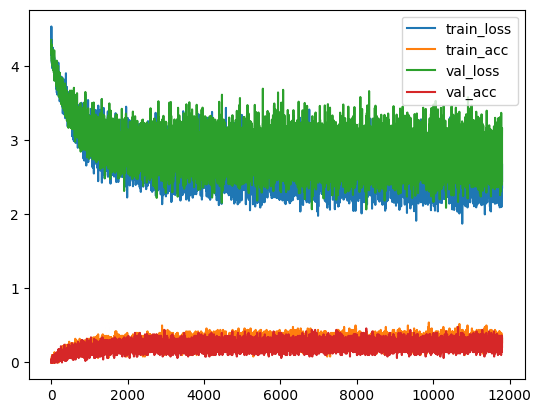

In [31]:
#ITERS=900
for i in range(ITERS):
    for phase in ['train','validate']:
      if phase=='train':
        # char_model.train()
        # получаем батч символов value и class
        batch=get_batch(TRAIN_DICT)
        batch_ix = to_matrix(batch)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        batch_ix=batch_ix.to(device)
        # prediction    
        if MODEL == 'rnn2' or MODEL == 'rnn':
          y_pred = rnn_loop(char_model, batch_ix)
        elif MODEL == 'lstm':
          y_pred = lstm_loop(char_model, batch_ix)
        else:
          # print(batch_ix)
          batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
          # print(batch_ix)
          # print(batch_ix.shape)
          y_pred = char_model(batch_ix) 
        # compute loss
        actual_tokens = [b.name for b in batch]
        y=string_vectorizer(actual_tokens)
        y=torch.tensor(y,dtype=torch.float64)
        y=y.to(device)
        loss = loss_func(y_pred,y)
        # visualizing training process
        history_train_loss.append(loss.data.cpu().numpy())
        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
        # считаем точность на обучении    
        pred_cl=np.argmax(y_pred.data.cpu().numpy(),axis=1)
        true_cl=np.argmax(y.data.cpu().numpy(),axis=1)
        accuracy = (pred_cl == true_cl).mean()
        history_train_acc.append(accuracy)
      else:
        # char_model.eval()
         # получаем батч символов value и class
        batch=get_batch(TEST_DICT)
        batch_ix = to_matrix(batch)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        batch_ix=batch_ix.to(device)
        # prediction    
        if MODEL == 'rnn2' or MODEL == 'rnn':
          y_pred = rnn_loop(char_model, batch_ix)
        elif MODEL == 'lstm':
          y_pred = lstm_loop(char_model, batch_ix)
        else:
          batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
          y_pred = char_model(batch_ix) 
        # compute loss
        actual_tokens = [b.name for b in batch]
        y=string_vectorizer(actual_tokens)
        y=torch.tensor(y,dtype=torch.float64)
        y=y.to(device)
        loss = loss_func(y_pred,y)
        # visualizing training process
        history_val_loss.append(loss.data.cpu().numpy())
        ####
        # считаем точность на валидации    
        pred_cl=np.argmax(y_pred.data.cpu().numpy(),axis=1)
        true_cl=np.argmax(y.data.cpu().numpy(),axis=1)
        accuracy = (pred_cl == true_cl).mean()
        history_val_acc.append(accuracy)
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history_train_loss,label='train_loss')
        plt.plot(history_train_acc,label='train_acc')
        plt.plot(history_val_loss,label='val_loss')
        plt.plot(history_val_acc,label='val_acc')
        plt.legend()
        plt.savefig('fig_train_chart_fft.png')
        plt.show()

assert np.mean(history_train_loss[:10]) > np.mean(history_train_loss[-10:]), "RNN didn't converge."
# char_model.eval();

In [32]:
char_model.cuda()
batch=get_batch(TEST_DICT)
batch_ix = to_matrix(batch)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
batch_ix=batch_ix.to(device)
if MODEL == 'rnn2' or MODEL == 'rnn':
  y_pred = rnn_loop(char_model, batch_ix)
elif MODEL == 'lstm':
  y_pred = lstm_loop(char_model, batch_ix) 
else:
  batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
  y_pred = char_model(batch_ix)     
pred_cl=np.argmax(y_pred.data.cpu().numpy(),axis=1)


batch_im=to_imagebatch(batch)
batch_im = torch.tensor(batch_im, dtype=torch.float32)
batch_im=batch_im.to(device)
# y_pred1=img_model(batch_im)
# pred_cl1=np.argmax(y_pred1.data.cpu().numpy(),axis=1)

actual_tokens = [b.name for b in batch]
y=string_vectorizer(actual_tokens)
y=torch.tensor(y,dtype=torch.float64)
true_cl=np.argmax(y.data.cpu().numpy(),axis=1)


print(np.array(CHAR_LIST)[pred_cl])
# print(np.array(CHAR_LIST)[pred_cl1])
print(np.array(CHAR_LIST)[true_cl])

accuracy = (pred_cl == true_cl).mean()
print(accuracy)

['C' 'p' 'z' 'A' 'p' 'U' 'H' 's' 'u' 'f' 'D' 'g' 'x' 'Z' 'y' 's' 'a' 'a'
 'C' 'z' '2' 'j' '4' 'c' 'U' 'X' 'v' 'r' '5' 'E' 'c' 'I' '4' 'O' 'W' 'G'
 '5' 'o' 'Q' 'c' 'd' 'X' 'R' 'w' 'r' 'M' 'H' 'w' 'U' 'I']
['G' 'R' 'y' 'A' 'd' 'K' 'F' 'S' '0' 'j' 'P' 'z' 'X' '2' 'Y' 's' 'm' 'q'
 'C' '7' 'Z' '8' 'N' '4' 'l' 'I' 'V' 'L' '3' 'a' 'f' 'i' 'h' 'O' 'w' 'b'
 '5' 'o' 'p' 'c' 'k' 'D' 'M' 'W' 'e' 'g' 'x' 'n' 'U' 'J']
0.16


/tmp/ipykernel_2538/4077844697.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  chars=random.sample(dict.keys(),size)
/tmp/ipykernel_2538/975259906.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_ix =torch.tensor( batch_ix, dtype=torch.float32)


In [33]:
torch.save(char_model.cpu(), os.path.join(CURRENT_FOLDER,"model"))
import sys
orig_stdout = sys.stdout

with open(os.path.join(CURRENT_FOLDER, 'model_'+MODEL+'_arch.txt'), 'w', encoding="utf-8") as f:
  sys.stdout = f
  f.write(str(char_model))


sys.stdout = orig_stdout


/tmp/ipykernel_2538/4077844697.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  chars=random.sample(dict.keys(),size)
/tmp/ipykernel_2538/885499728.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_ix =torch.tensor( batch_ix, dtype=torch.float32)


--- 0.28211164474487305 seconds ---
[[21  0  0 ...  0  0  0]
 [ 0  4  2 ...  3  0  1]
 [ 0  0 10 ...  0  0 10]
 ...
 [ 0  0  0 ... 12  2  0]
 [ 0  0  0 ...  1 10  3]
 [ 0  0 15 ...  0  0  5]]


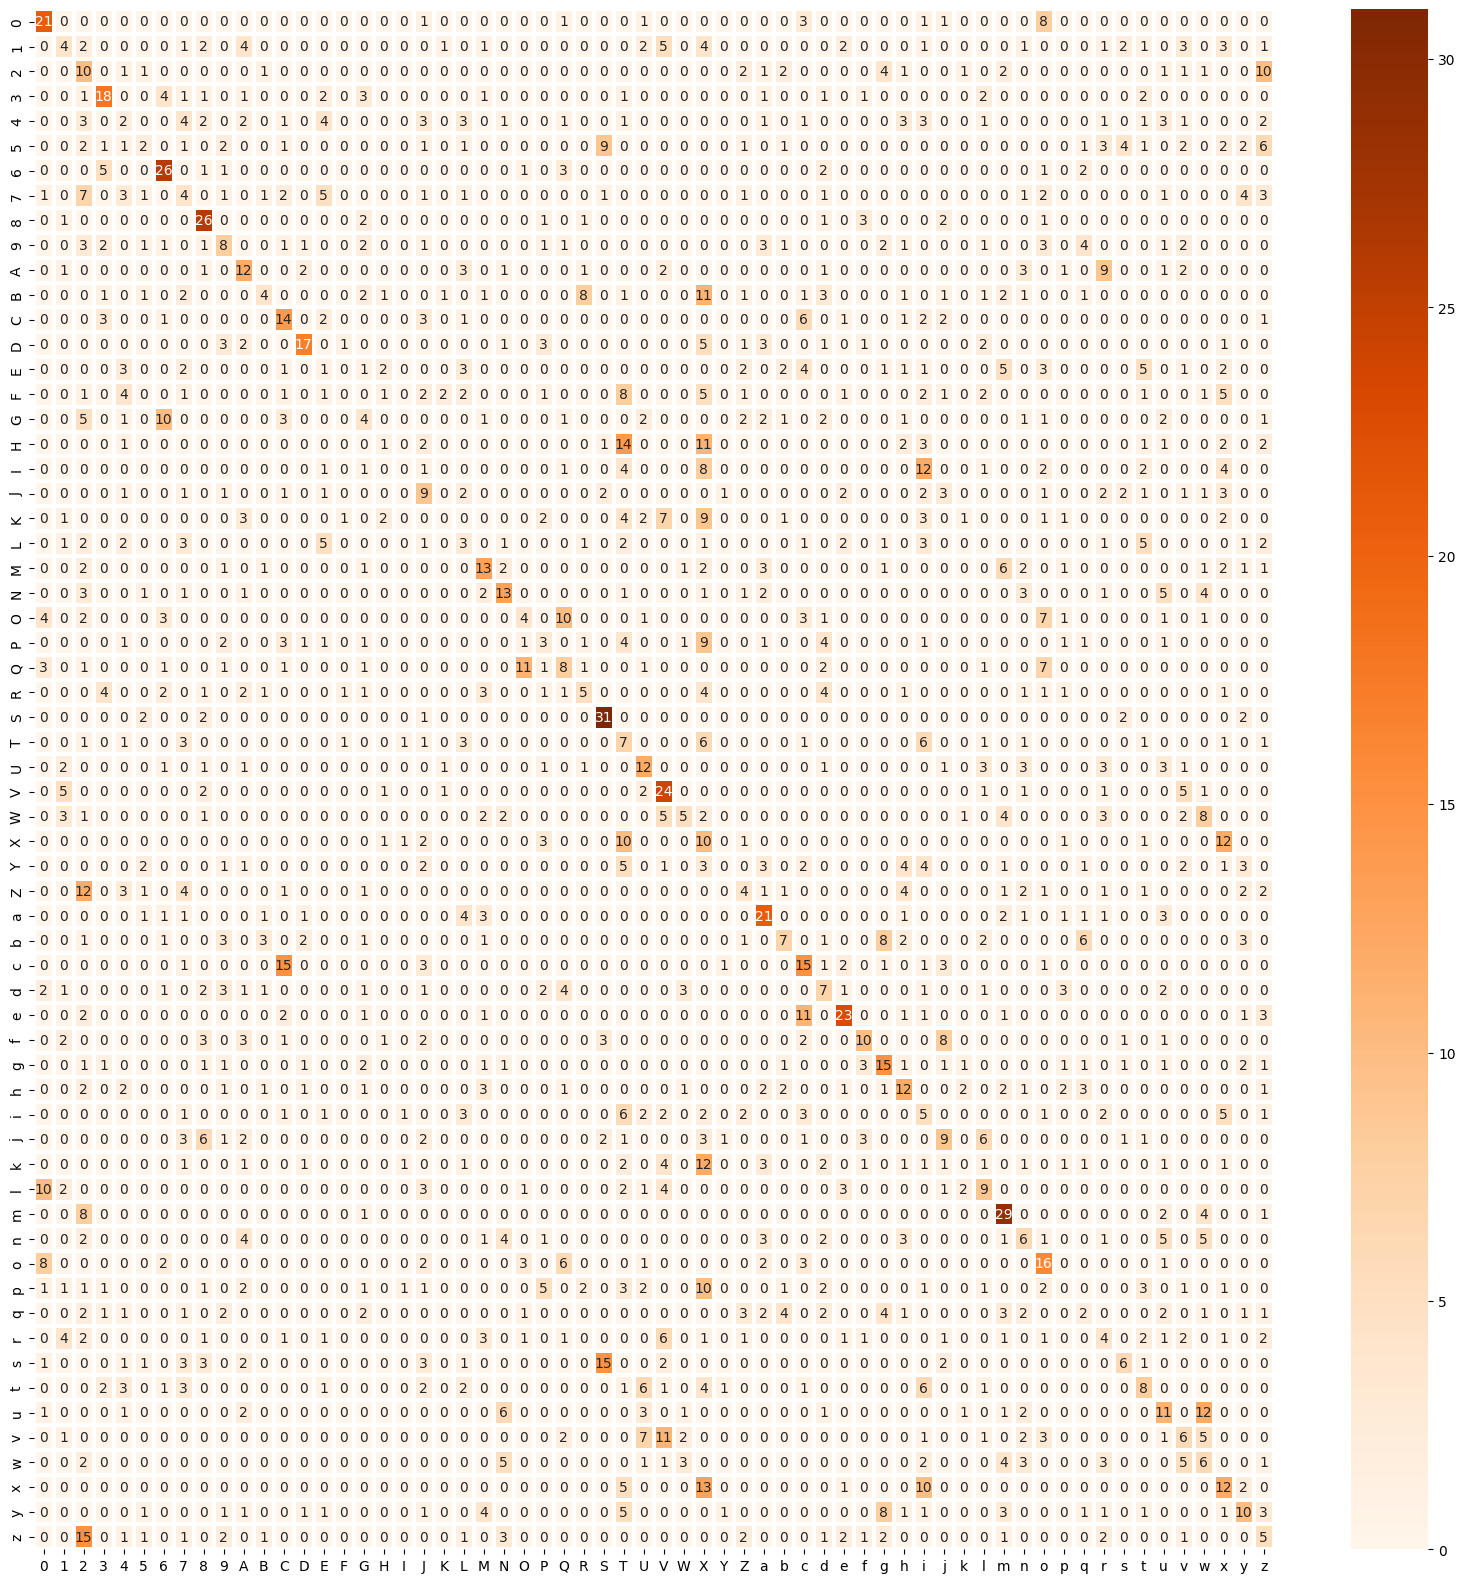

In [34]:
from pandas import DataFrame
from sklearn import metrics

char_model.cuda()
class_names =  CHAR_LIST
true_labels=[]
pred_labels=[]
start_time = time.time()
for i in range(50):
  batch=get_batch(TEST_DICT)
  batch_ix = to_matrix(batch)
  batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
  batch_ix=batch_ix.to(device)
  if MODEL == 'rnn2' or MODEL == 'rnn':
    y_pred = rnn_loop(char_model, batch_ix)
  elif MODEL == 'lstm':
        y_pred = lstm_loop(char_model, batch_ix)
  else:
    batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
    y_pred = char_model(batch_ix)     
  actual_tokens = [b.name for b in batch]
  y=string_vectorizer(actual_tokens)
  y=torch.tensor(y,dtype=torch.float64)
  pred_cl=np.argmax(y_pred.data.cpu().numpy(),axis=1)
  true_cl=np.argmax(y.data.cpu().numpy(),axis=1)
  pred_labels.extend(pred_cl)
  true_labels.extend(true_cl)
print("--- %s seconds ---" % (time.time() - start_time))

cm=metrics.confusion_matrix(true_labels,pred_labels)
df_cm = DataFrame(cm, index=class_names, columns=class_names)
print(cm)
from pandas import DataFrame
import seaborn as sn
plt.subplots(figsize=(20,20))
sn.heatmap(df_cm,annot=True, fmt="d",linewidths=1.5,cmap="Oranges",)
plt.savefig('fig_confusion_matrix_fft.png')
plt.show()

In [153]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(CHAR_LIST))

    def forward(self, x):
        x = F.max_pool2d(F.tanh(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

net = LeNet().cuda()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=62, bias=True)
)


In [154]:
opt = torch.optim.Adam(net.parameters(),lr=0.001)
loss_func=torch.nn.CrossEntropyLoss()
history_train_loss = []
history_train_acc = []
history_val_loss = []
history_val_acc = []

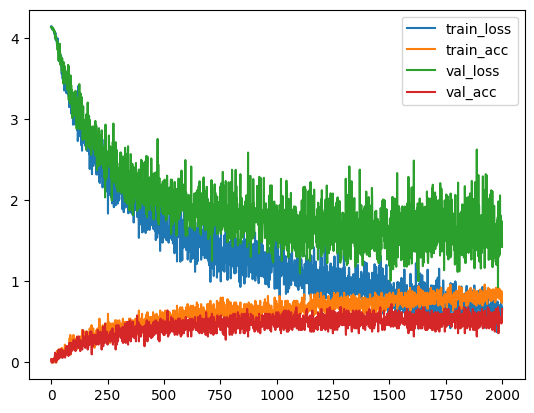

In [155]:
ITERS=2000
for i in range(ITERS):
    for phase in ['train','validate']:
      if phase=='train':
        net.train()
        # получаем батч символов value и class
        batch,actual_tokens,_=get_batch_img(TRAIN_DICT)
        batch_ix = torch.tensor(batch, dtype=torch.int64)
        batch_ix=batch_ix.to(device)
        # prediction    
        batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
        y_pred = net(batch_ix) 
        # compute loss
        # actual_tokens = [b.name for b in batch]
        y=string_vectorizer(actual_tokens)
        y=torch.tensor(y,dtype=torch.float64)
        y=y.to(device)
        loss = loss_func(y_pred,y)
        ####
        history_train_loss.append(loss.data.cpu().numpy())
        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
        # считаем точность на обучении    
        pred_cl=np.argmax(y_pred.data.cpu().numpy(),axis=1)
        true_cl=np.argmax(y.data.cpu().numpy(),axis=1)
        accuracy = (pred_cl == true_cl).mean()
        history_train_acc.append(accuracy)
      else:
        net.eval()
         # получаем батч символов value и class
        batch,actual_tokens,_=get_batch_img(TEST_DICT)
        batch_ix = torch.tensor(batch, dtype=torch.int64)
        batch_ix=batch_ix.to(device)
        # prediction    
        batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
        y_pred = net(batch_ix) 
        # compute loss
        # actual_tokens = [b.name for b in batch]
        y=string_vectorizer(actual_tokens)
        y=torch.tensor(y,dtype=torch.float64)
        y=y.to(device)
        loss = loss_func(y_pred,y)
        # visualizing training process
        history_val_loss.append(loss.data.cpu().numpy())
        ####
        # считаем точность на валидации    
        pred_cl=np.argmax(y_pred.data.cpu().numpy(),axis=1)
        true_cl=np.argmax(y.data.cpu().numpy(),axis=1)
        accuracy = (pred_cl == true_cl).mean()
        history_val_acc.append(accuracy)
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history_train_loss,label='train_loss')
        plt.plot(history_train_acc,label='train_acc')
        plt.plot(history_val_loss,label='val_loss')
        plt.plot(history_val_acc,label='val_acc')
        plt.legend()
        plt.savefig('fig_train_chart_lenet.png')
        plt.show()

In [156]:
batch,actual_tokens,_=get_batch_img(TEST_DICT)
batch_ix = torch.tensor(batch, dtype=torch.int64)
batch_ix=batch_ix.to(device)
# prediction    
batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
y_pred = net(batch_ix) 
print(y_pred.shape)
y=string_vectorizer(actual_tokens)
y=torch.tensor(y,dtype=torch.float64)
pred_cl=np.argmax(y_pred.data.cpu().numpy(),axis=1)
true_cl=np.argmax(y.data.cpu().numpy(),axis=1)

print(np.array(CHAR_LIST)[pred_cl])
print(np.array(CHAR_LIST)[true_cl])

accuracy = (pred_cl == true_cl).mean()
print(accuracy)

torch.Size([50, 62])
['k' 'g' 'C' 'R' 'E' 'q' '3' 'k' 'l' 'o' 'D' 't' 'h' 'N' '0' 'u' 'c' 'U'
 'l' 'a' 'F' '4' 'A' 'P' 'x' 'p' 'M' 'a' 'z' 'T' '5' 'U' 'r' 'p' 'T' 'l'
 'w' 'K' 'I' 'h' 'W' 'Q' 'O' 'Y' 'J' 'J' 'H' 't' '6' 'i']
['X' 'g' 'C' 'R' 'E' 'y' 'J' 'k' '8' 'o' 'D' 'Z' 'b' 'M' '0' 'w' 'e' 'U'
 '1' 'a' 'F' '9' 'A' 'P' 'V' 'B' 'N' 'd' 'z' 'T' 'S' 'u' 'x' 'p' 'q' '2'
 'W' 'K' 'I' 'h' 'v' 'Q' 'O' 'Y' 'j' 'f' '4' 't' 'G' 'i']
0.48


/tmp/ipykernel_2538/4077844697.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  chars=random.sample(dict.keys(),size)
/tmp/ipykernel_2538/3709373892.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_ix =torch.tensor( batch_ix, dtype=torch.float32)


In [157]:
char_model.cuda()
accuracy=np.array([])
accuracy2=np.array([])
accuracy3=np.array([])
for i in range(200):
    # get batch from test datatset
    batch1,actual_tokens,batch2=get_batch_img(TEST_DICT)
    batch_ix = to_matrix(batch2)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    batch_ix=batch_ix.to(device)
    # predict by dynamic model 
    if MODEL == 'rnn2' or MODEL == 'rnn':
      y_pred = rnn_loop(char_model, batch_ix)
    elif MODEL == 'lstm':
      y_pred = lstm_loop(char_model, batch_ix) 
    else:
      batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
      y_pred = char_model(batch_ix)     
    pred_cl=np.argmax(y_pred.data.cpu().numpy(),axis=1)
    # predict by baseline
    batch_ix = torch.tensor(batch1, dtype=torch.int64)
    batch_ix=batch_ix.to(device)
    batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
    y_pred2 = net(batch_ix) 
    pred_cl2=np.argmax(y_pred2.data.cpu().numpy(),axis=1)    
    # predict ansamble
    y_pred3=y_pred+y_pred2
    pred_cl3=np.argmax(y_pred3.data.cpu().numpy(),axis=1)
    # real classes
    y=string_vectorizer(actual_tokens)
    y=torch.tensor(y,dtype=torch.float64)
    true_cl2=np.argmax(y.data.cpu().numpy(),axis=1)
    # calculate accuracy
    accuracy=np.append(accuracy,(pred_cl == true_cl2))
    accuracy2=np.append(accuracy2,(pred_cl2 == true_cl2))
    accuracy3=np.append(accuracy3,(pred_cl3 == true_cl2))
# print accuracy
print("acc for dynamic feature: {}".format(accuracy.mean()))
print("acc baseline feature: {}".format(accuracy2.mean()))
print("acc ansamble: {}".format(accuracy3.mean()))

/tmp/ipykernel_2538/4077844697.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  chars=random.sample(dict.keys(),size)
/tmp/ipykernel_2538/3532837497.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
/tmp/ipykernel_2538/3532837497.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
/usr/lib64/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


acc for dynamic feature: 0.2863
acc baseline feature: 0.5353
acc ansamble: 0.6239


In [158]:
from torchsummary import summary
char_model.eval()
summary(net.cuda(),input_size= (BATCH_SIZE,IMG_H,IMG_W))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 62]           5,270
Total params: 66,126
Trainable params: 66,126
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


/usr/lib64/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [159]:
class ImgNet(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_inputs, num_classes):    
        super(self.__class__,self).__init__()
        self.fc1 = nn.Linear(num_inputs , 3*num_classes)
        self.act1= nn.Sigmoid()
        self.fc2 = nn.Linear(3*num_classes , 2*num_classes)
        self.act2= nn.Sigmoid()
        self.fc3 = nn.Linear(2*num_classes , num_classes)

    def forward(self, x):
        return self.fc3(self.act2(self.fc2(self.act1(self.fc1(x)))))
  

In [160]:
img_model= ImgNet(IMG_W*IMG_H,len(CHAR_LIST))
img_model=img_model.to(device)

In [161]:
opt = torch.optim.AdamW(img_model.parameters(),lr=0.001)
loss_func=torch.nn.CrossEntropyLoss()
history_train_loss = []
history_train_acc = []
history_val_loss = []
history_val_acc = []

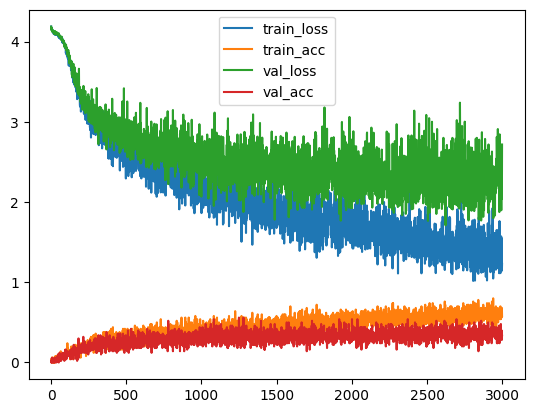

In [162]:
accuracy=np.array([])
ITERS=3000
for i in range(ITERS):
    for phase in ['train','validate']:
      if phase=='train':
        img_model.train()
        # получаем батч символов value и class
        batch,actual_tokens,_=get_batch_img(TRAIN_DICT)
        batch_ix = torch.tensor(batch, dtype=torch.int64)
        batch_ix=batch_ix.to(device)
        # prediction    
        batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
        y_pred = img_model(batch_ix.reshape(BATCH_SIZE,IMG_W*IMG_H)) 
        # compute loss
        # actual_tokens = [b.name for b in batch]
        y=string_vectorizer(actual_tokens)
        y=torch.tensor(y,dtype=torch.float64)
        y=y.to(device) 
        # print((y_pred.shape,y.shape))
        loss = loss_func(y_pred,y)
        ####
        history_train_loss.append(loss.data.cpu().numpy())
        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
        # считаем точность на обучении    
        pred_cl=np.argmax(y_pred.data.cpu().numpy(),axis=1)
        true_cl=np.argmax(y.data.cpu().numpy(),axis=1)
        accuracy = (pred_cl == true_cl).mean()
        history_train_acc.append(accuracy)
      else:
        img_model.eval()
         # получаем батч символов value и class
        batch,actual_tokens,_=get_batch_img(TEST_DICT)
        batch_ix = torch.tensor(batch, dtype=torch.int64)
        batch_ix=batch_ix.to(device)
        # prediction    
        batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
        y_pred = img_model(batch_ix.reshape(BATCH_SIZE,IMG_W*IMG_H)) 
        # compute loss
        # actual_tokens = [b.name for b in batch]
        y=string_vectorizer(actual_tokens)
        y=torch.tensor(y,dtype=torch.float64)
        y=y.to(device)
        loss = loss_func(y_pred,y)
        # visualizing training process
        history_val_loss.append(loss.data.cpu().numpy())
        ####
        # считаем точность на валидации    
        pred_cl=np.argmax(y_pred.data.cpu().numpy(),axis=1)
        true_cl=np.argmax(y.data.cpu().numpy(),axis=1)
        accuracy = (pred_cl == true_cl).mean()
        history_val_acc.append(accuracy)
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history_train_loss,label='train_loss')
        plt.plot(history_train_acc,label='train_acc')
        plt.plot(history_val_loss,label='val_loss')
        plt.plot(history_val_acc,label='val_acc')
        plt.legend()
        plt.savefig('fig_train_chart_img_model3.png')
        plt.show()

In [183]:
img_model.cuda()
char_model.eval()
accuracy2=np.array([])
for i in range(200):
    # predict by baseline
    batch,actual_tokens,_=get_batch_img(TEST_DICT)
    batch_ix = torch.tensor(batch, dtype=torch.int64)
    batch_ix=batch_ix.to(device)
    batch_ix =torch.tensor( batch_ix, dtype=torch.float32)
    y_pred = img_model(batch_ix.reshape(BATCH_SIZE,IMG_W*IMG_H)) 
    pred_cl2=np.argmax(y_pred.data.cpu().numpy(),axis=1)    
    # real classes
    y=string_vectorizer(actual_tokens)
    y=torch.tensor(y,dtype=torch.float64)
    true_cl2=np.argmax(y.data.cpu().numpy(),axis=1)
    # calculate accuracy
    accuracy2=np.append(accuracy2,(pred_cl2 == true_cl2))
# print accuracy
print("acc baseline feature: {}".format(accuracy2.mean()))

/tmp/ipykernel_2538/4077844697.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  chars=random.sample(dict.keys(),size)
/tmp/ipykernel_2538/1497735923.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_ix =torch.tensor( batch_ix, dtype=torch.float32)


acc baseline feature: 0.3588


In [163]:
from torchsummary import summary
img_model.eval()
summary(img_model.cuda(),input_size= (BATCH_SIZE,IMG_W*IMG_H))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 50, 186]         190,650
           Sigmoid-2              [-1, 50, 186]               0
            Linear-3              [-1, 50, 124]          23,188
           Sigmoid-4              [-1, 50, 124]               0
            Linear-5               [-1, 50, 62]           7,750
Total params: 221,588
Trainable params: 221,588
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 0.26
Params size (MB): 0.85
Estimated Total Size (MB): 1.30
----------------------------------------------------------------


In [ ]:
ITERS=20
for i in range(ITERS):
    img_model.train()
    # получаем батч символов value и class
    batch,actual_tokens,_=get_batch_img(TRAIN_DICT)
    y_pred=classifier.predict(batch_ix.reshape(BATCH_SIZE,IMG_W*IMG_H))
    print(accuracy_score(y_pred,actual_tokens))
